# **Ejercicio 9 - Procesamiento del Imágenes y Visión por Computadora**
# *Alumno: Lucas Demarré*
# *Año: 2024*

---

# **Tabla de contenidos**

1.   [**Librerías**](#)
2.   [**Presentación de Imágenes**](#)
        1.   [*Primera imagen (sin solapamiento)*](#)
        2.   [*Segunda imagen (con solapamiento)*](#)
3.   [**Métodos de Segmentación**](#)
        1.   [*Mask R-CNN (OpenCV)*](#)
                1.   [**Descargamos los archivos necesarios**](#)
                2.   [**Hacemos la función para hacer la Segmentación**](#)
        2.   [*SAM (Segment Anything Model)*](#)
                1.   [**Descargamos el modelo SAM**](#)
                2.   [**Hacemos la función para hacer la Segmentación**](#)
        3.   [*Panoptic segmentation con modelo DETR ResNet50 (Transformers)*](#)
                1.   [**Hacemos la función para hacer la Segmentación**](#)
4.   [**Mostramos la Segmentación**](#)
        1.   [*Segmentación Mask R-CNN*](#)
                1.   [**Primera imagen (sin solapamiento)**](#)
                2.   [**Segunda imagen (con solapamiento)**](#)
        2.   [*Segmentación SAM*](#)
                1.   [**Primera imagen (sin solapamiento)**](#)
                2.   [**Segunda imagen (con solapamiento)**](#)
        3.   [*Segmentación DETR ResNet50*](#)
                1.   [**Primera imagen (sin solapamiento)**](#)
                2.   [**Segunda imagen (con solapamiento)**](#)
5.   [**Conclusiones**](#)

# 1. **Librerías**

In [14]:
import os
import io
import sys
import time
import torch
import random
import tarfile
import requests
import itertools
import cv2 as cv
import numpy as np
import torchvision
import urllib.request
import seaborn as sns
import supervision as sv
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from transformers import DetrFeatureExtractor, DetrForSegmentation
from transformers.models.detr.feature_extraction_detr import rgb_to_id
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# 2. **Presentación de Imágenes**

## 2.1. *Primera imagen (sin solapamiento)*

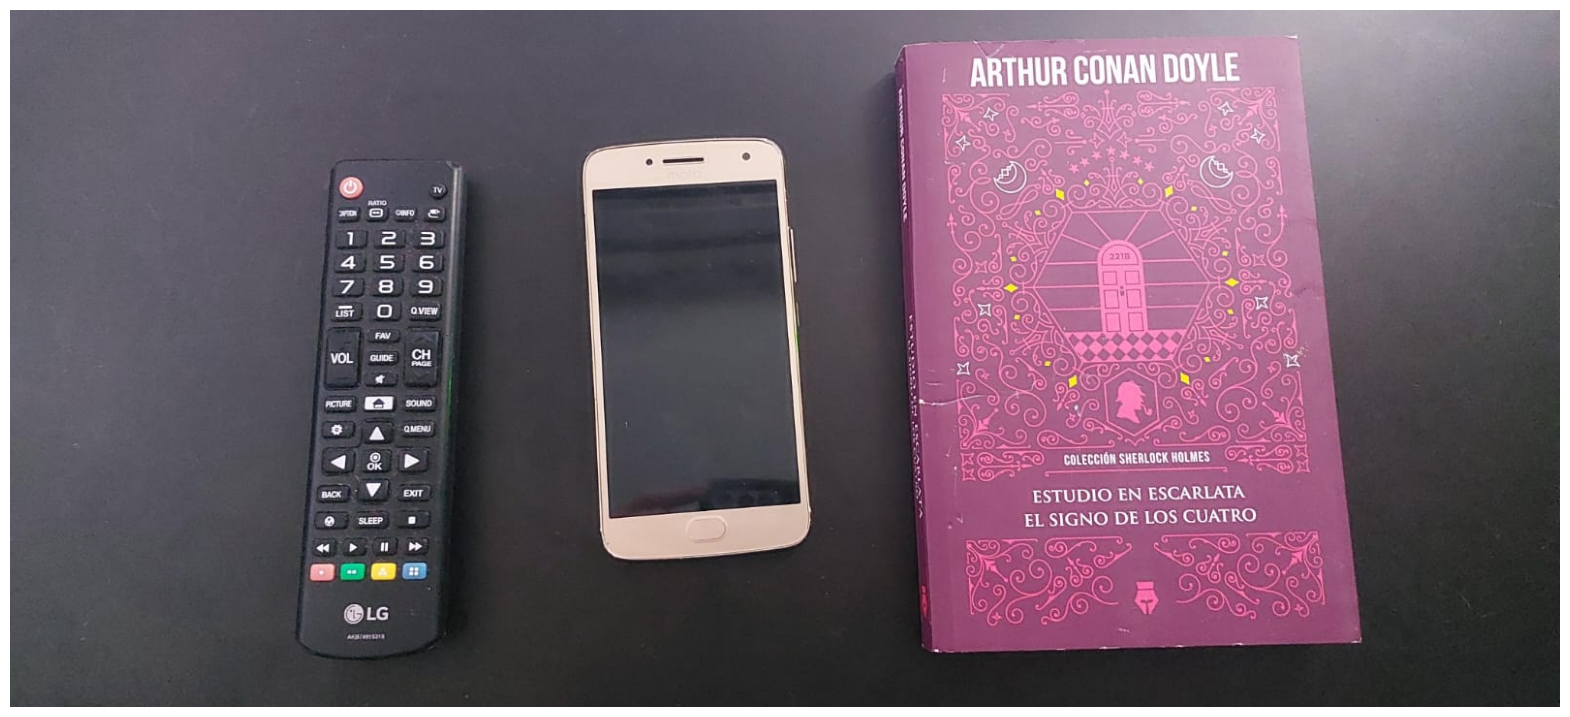

In [4]:
image = cv.imread('Escenarios/escenario_1.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## 2.2. *Segunda imagen (con solapamiento)*

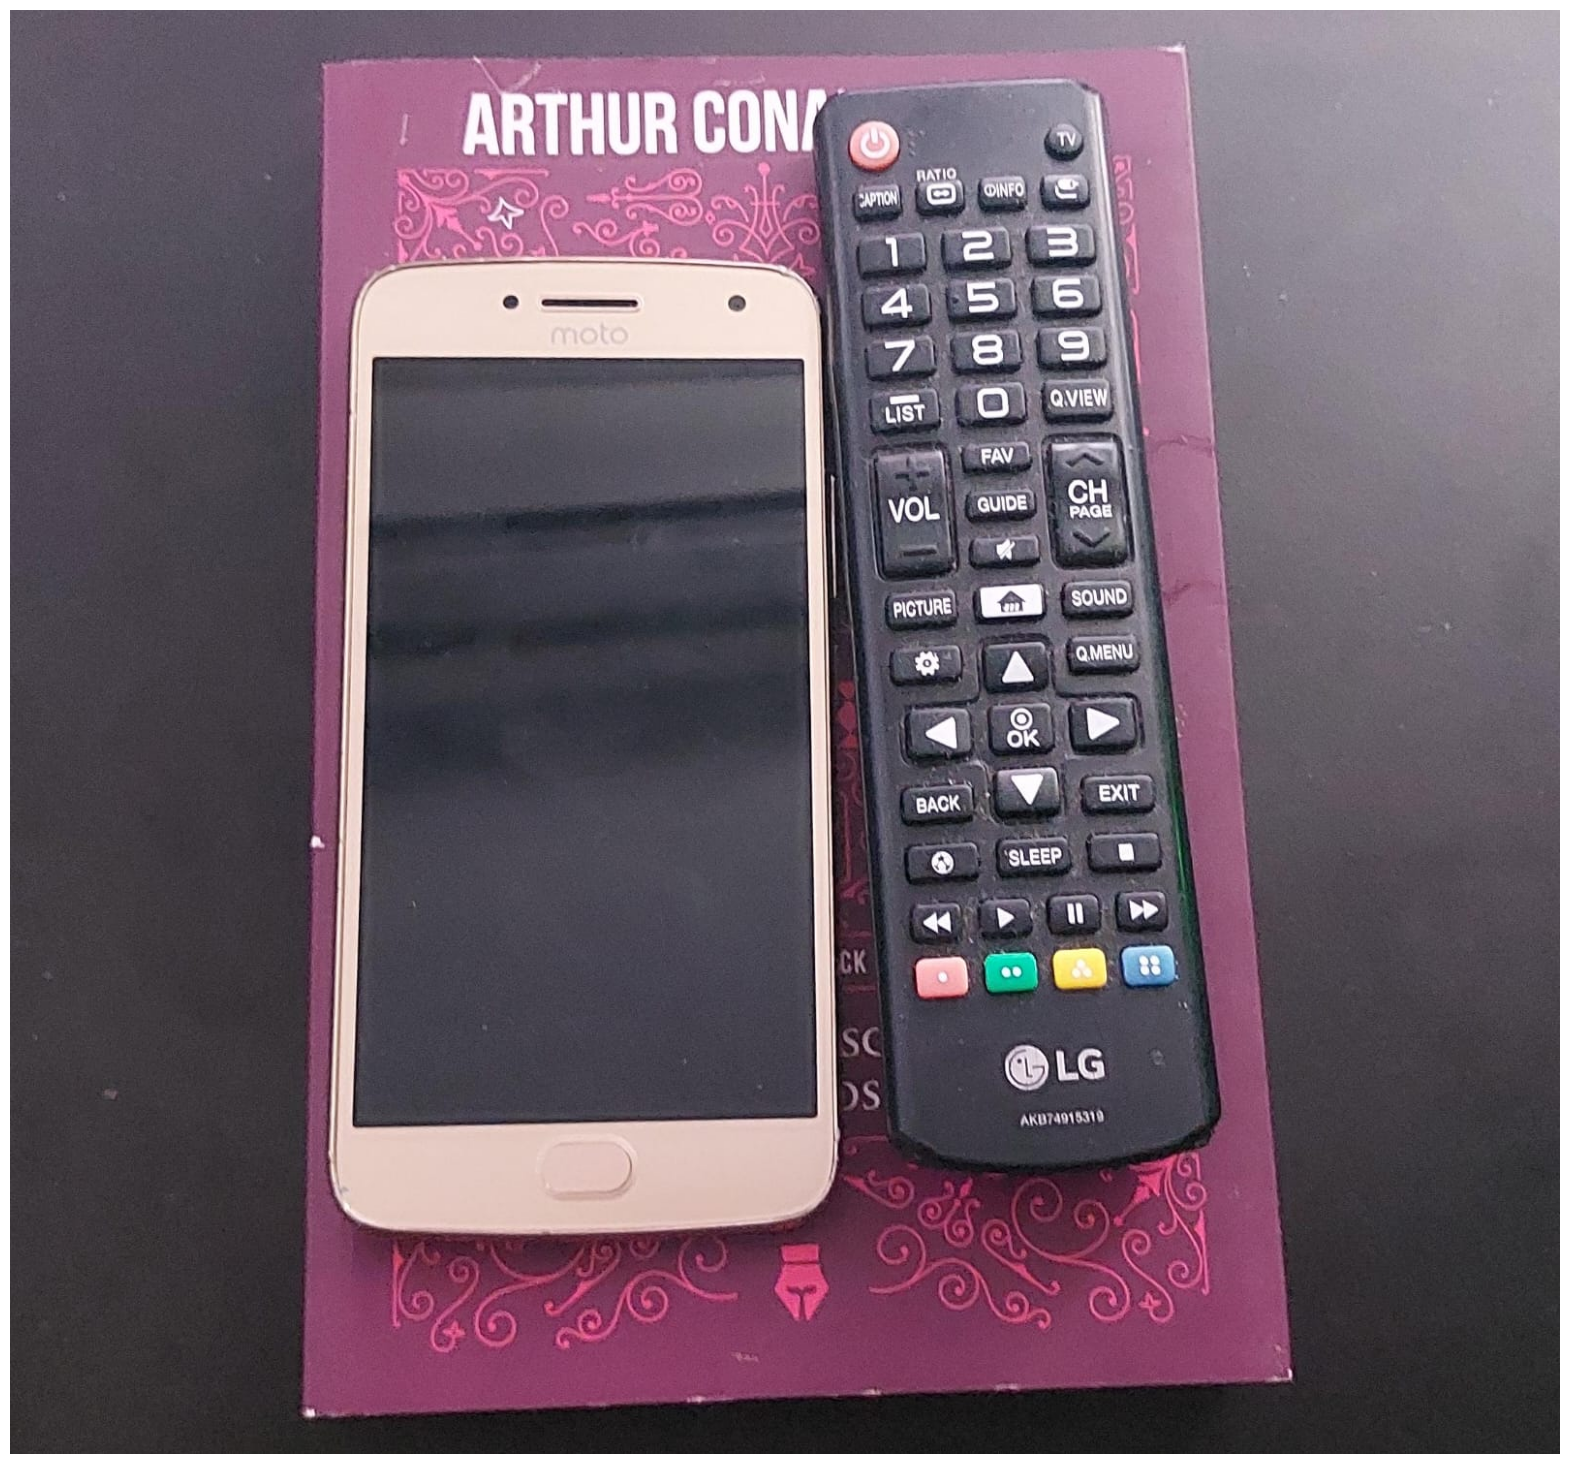

In [5]:
image = cv.imread('Escenarios/escenario_2.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

# 3. **Métodos de Segmentación**

## 3.1. *Mask R-CNN (OpenCV)*

### 3.1.1. **Descargamos los archivos necesarios**

In [6]:
# Dirección donde se guardarán los archivos
folder_path = 'Algoritmos/Mask R-CNN (OpenCV)'

# Descargar el archivo mask_rcnn_inception_v2_coco_2018_01_28.tar.gz
url = 'http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz'
file_path = os.path.join(folder_path, 'mask_rcnn_inception_v2_coco_2018_01_28.tar.gz')
urllib.request.urlretrieve(url, file_path)

# Extraer el archivo
with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall(folder_path)

# Descargar los otros archivos de utilidad
urllib.request.urlretrieve('https://raw.githubusercontent.com/spmallick/learnopencv/master/Mask-RCNN/mscoco_labels.names', os.path.join(folder_path, 'mscoco_labels.names'))
urllib.request.urlretrieve('https://raw.githubusercontent.com/spmallick/learnopencv/master/Mask-RCNN/colors.txt', os.path.join(folder_path, 'colors.txt'))
urllib.request.urlretrieve('https://raw.githubusercontent.com/spmallick/learnopencv/master/Mask-RCNN/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt', os.path.join(folder_path, 'mask_rcnn_inception_v2_coco_2018_01_28.pbtxt'))

('Algoritmos/Mask R-CNN (OpenCV)\\mask_rcnn_inception_v2_coco_2018_01_28.pbtxt',
 <http.client.HTTPMessage at 0x1cf6f545a10>)

### 3.1.2. **Hacemos la función para hacer la Segmentación**

In [7]:
# Función para hacer y mostrar la segmentación
def process_image_R_CNN(image_path):
    # Umbral de confianza para las detecciones
    confThreshold = 0.8
    # Umbral para las máscaras de segmentación
    maskThreshold = 0.3
    
    # Nuevas rutas de los archivos
    classesFile = 'Algoritmos/Mask R-CNN (OpenCV)/mscoco_labels.names'
    colorsFile = 'Algoritmos/Mask R-CNN (OpenCV)/colors.txt'
    textGraph = 'Algoritmos/Mask R-CNN (OpenCV)/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt'
    modelWeights = 'Algoritmos/Mask R-CNN (OpenCV)/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'
    
    # Cargar los nombres de las clases de MSCOCO
    classes = None
    with open(classesFile, 'rt') as f:
        classes = f.read().rstrip('\n').split('\n')
    
    # Cargar los colores para visualizar las detecciones
    colors = []
    with open(colorsFile, 'rt') as f:
        colorsStr = f.read().rstrip('\n').split('\n')
        for i in range(len(colorsStr)):
            rgb = colorsStr[i].split(' ')
            color = np.array([float(rgb[0]), float(rgb[1]), float(rgb[2])])
            colors.append(color)
    
    # Cargar la red
    net = cv.dnn.readNetFromTensorflow(modelWeights, textGraph)
    net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
    net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)
    
    # Cargar la imagen y obtener sus dimensiones
    image = cv.imread(image_path)
    (H, W) = image.shape[:2]
    
    # Crear un blob de la imagen y realizar una pasada hacia adelante con Mask R-CNN
    blob = cv.dnn.blobFromImage(image, swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    (boxes, masks) = net.forward(['detection_out_final', 'detection_masks'])
    end = time.time()
    
    # Creamos una copia de la imagen original, para dibujar las máscaras
    output_image = image.copy()
    
    for i in range(0, boxes.shape[2]):
        confidence = boxes[0, 0, i, 2]
        if confidence > confThreshold:
            classId = int(boxes[0, 0, i, 1])
            box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H])
            (startX, startY, endX, endY) = box.astype('int')
    
            # Redimensiona la máscara para que se ajuste a la caja delimitadora y la convierte en uint8
            mask = masks[i, classId]
            mask = cv.resize(mask, (endX - startX, endY - startY))
            mask = (mask > maskThreshold).astype('uint8')
    
            # Extrae la región de interés (ROI) usando las coordenadas de la caja delimitadora
            roi = output_image[startY:endY, startX:endX]
    
            # Crea una imagen de color sólido para la máscara
            color = random.choice(colors)
            color_mask = np.zeros_like(roi)
            color_mask[mask == 1] = color
    
            # Mezcla la imagen de color con la ROI utilizando la máscara
            roi = cv.addWeighted(roi, 1, color_mask, 0.4, 0)
    
            # Vuelve a colocar la ROI en la imagen original
            output_image[startY:endY, startX:endX] = roi
    
            # Dibuja la caja delimitadora
            cv.rectangle(output_image, (startX, startY), (endX, endY), color, 2)
    
            # Consigue el nombre de la clase y el color correspondiente
            classId = int(boxes[0, 0, i, 1])
            className = classes[classId]
    
            # Dibuja el rectángulo de la caja delimitadora y la etiqueta de la clase
            label = f"{className}: {confidence:.2f}"
            cv.rectangle(output_image, (startX, startY), (endX, endY), color, 2)
            cv.putText(output_image, label, (startX, startY - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    # Configurar los subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # Mostrar la imagen original
    axes[0].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    axes[0].set_title('Imagen Original')
    axes[0].axis('off')  # Ocultar los ejes
    
    # Mostrar la imagen segmentada
    axes[1].imshow(cv.cvtColor(output_image, cv.COLOR_BGR2RGB))
    axes[1].set_title('Imagen Segmentada')
    axes[1].axis('off')  # Ocultar los ejes
    
    # Mostrar ambas imágenes
    plt.show()

## 3.2. *SAM (Segment Anything Model)*

### 3.2.1. **Descargamos el modelo SAM**

In [10]:
!{sys.executable} -m pip install git+https://github.com/facebookresearch/segment-anything.git
!{sys.executable} -m pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision
urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth', 'Algoritmos/SAM (Segment Anything Model)/sam_vit_h_4b8939.pth')

  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\lucas\appdata\local\temp\pip-req-build-u2ldpx2i
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git 'C:\Users\lucas\AppData\Local\Temp\pip-req-build-u2ldpx2i'


('Algoritmos/SAM (Segment Anything Model)/sam_vit_h_4b8939.pth',
 <http.client.HTTPMessage at 0x1cf6f571c10>)

### 3.2.2. **Hacemos la función para hacer la Segmentación**

In [11]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

# Función para mostrar la segmentación de SAM
def show_segmentation_SAM(image_path):
    sys.path.append('..')

    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
    sam_checkpoint = 'Algoritmos/SAM (Segment Anything Model)/sam_vit_h_4b8939.pth'
    model_type = 'vit_h'
    
    device = 'cpu'
    
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    
    mask_generator = SamAutomaticMaskGenerator(sam)
    
    masks = mask_generator.generate(image)
    
    # Cargamos la imagen y convertirmos de BGR a RGB
    image_bgr = cv.imread(image_path)
    image_rgb = cv.cvtColor(image_bgr, cv.COLOR_BGR2RGB)
    
    # Inicializarmos el anotador de máscaras con una búsqueda de color por índice
    mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
    
    # Inicializamos el generador de máscaras automáticas SAM
    mask_generator = SamAutomaticMaskGenerator(sam)
    
    # Generamos máscaras automáticamente para la imagen RGB
    sam_result = mask_generator.generate(image_rgb)
    
    # Convertimos el resultado de SAM en detecciones
    detections = sv.Detections.from_sam(sam_result=sam_result)
    
    # Anotamos la imagen con las detecciones generadas por SAM
    annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
    
    # Mostramos la imagen original y la anotada en una cuadrícula
    sv.plot_images_grid(
        images=[image_bgr, annotated_image],
        grid_size=(1, 2),
        titles=['Imagen original', 'Imagen segmentada']
    )

## 3.3. *Panoptic segmentation con modelo DETR ResNet50 (Transformers)*

### 3.3.1. **Hacemos la función para hacer la Segmentación**

In [15]:
def show_segmentation_DETR(image_path):
    # Cargamos la imagen
    image = cv.imread(image_path)
    
    # Cargamos el modelo y el extractor de características
    feature_extractor = DetrFeatureExtractor.from_pretrained('facebook/detr-resnet-50-panoptic')
    model = DetrForSegmentation.from_pretrained('facebook/detr-resnet-50-panoptic')
    
    # Preparar la imagen para el modelo
    inputs = feature_extractor(images=image, return_tensors='pt')
    
    # Paso forward
    outputs = model(**inputs)
    
    # Postprocesamiento
    processed_sizes = torch.as_tensor(inputs['pixel_values'].shape[-2:]).unsqueeze(0)
    result = feature_extractor.post_process_panoptic(outputs, processed_sizes, threshold=0.85)[0]
    
    # Convertir la segmentación a numpy
    panoptic_seg = Image.open(io.BytesIO(result['png_string']))
    panoptic_seg = np.array(panoptic_seg, dtype=np.uint8)
    panoptic_seg_id = rgb_to_id(panoptic_seg)
    
    # Preparar la paleta de colores
    palette = itertools.cycle(sns.color_palette())
    
    # Crear la imagen segmentada
    segmented_image = Image.fromarray(np.zeros_like(panoptic_seg, dtype=np.uint8))
    draw = ImageDraw.Draw(segmented_image)
    
    # Añadimos un mapeo manual de los IDs de las categorías a los nombres, basado en las clases comunes de COCO
    COCO_LABELS = { 75: 'control remoto', 77: 'teléfono celular', 84: 'libro' }
    
    # Ajusta el bucle para dibujar segmentos y etiquetas correctamente
    for segment_info in result['segments_info']:
        class_id = segment_info['category_id']
        class_name = COCO_LABELS.get(class_id, 'Desconocido')  # 'Desconocido' si el ID no está en el diccionario
        id = segment_info['id']
    
        # Generar la máscara para este segmento específico
        mask = panoptic_seg_id == id
        color = np.array(next(palette)) * 255  # Convertir el color a un array de numpy adecuado
    
        # Convertir la máscara a una imagen de PIL para usarla como máscara en 'paste'
        mask_image = Image.fromarray((mask * 255).astype(np.uint8))
    
        # Crear una imagen del color del segmento que tenga las dimensiones correctas
        color_image = Image.new('RGB', segmented_image.size, color=tuple(color.astype(int)))
    
        # Pegar usando la máscara para aplicar solo este segmento
        segmented_image.paste(color_image, (0,0), mask=mask_image)
    
        # Dibujar el nombre de la clase en la posición inicial del segmento
        draw = ImageDraw.Draw(segmented_image)
        where = np.where(mask)
        if where[0].size > 0 and where[1].size > 0:
            x, y = np.min(where[1]), np.min(where[0])
            draw.text((x, y), class_name, fill='white')
    
    # Mostrar la imagen original y la segmentada
    plt.figure(figsize=(30, 15))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Imagen Original')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image)
    plt.title('Imagen Segmentada con Etiquetas')
    plt.axis('off')
    
    plt.show()

# 4. **Mostramos la Segmentación**

## 4.1. *Segmentación Mask R-CNN*

### 4.1.1. **Primera imagen (sin solapamiento)**

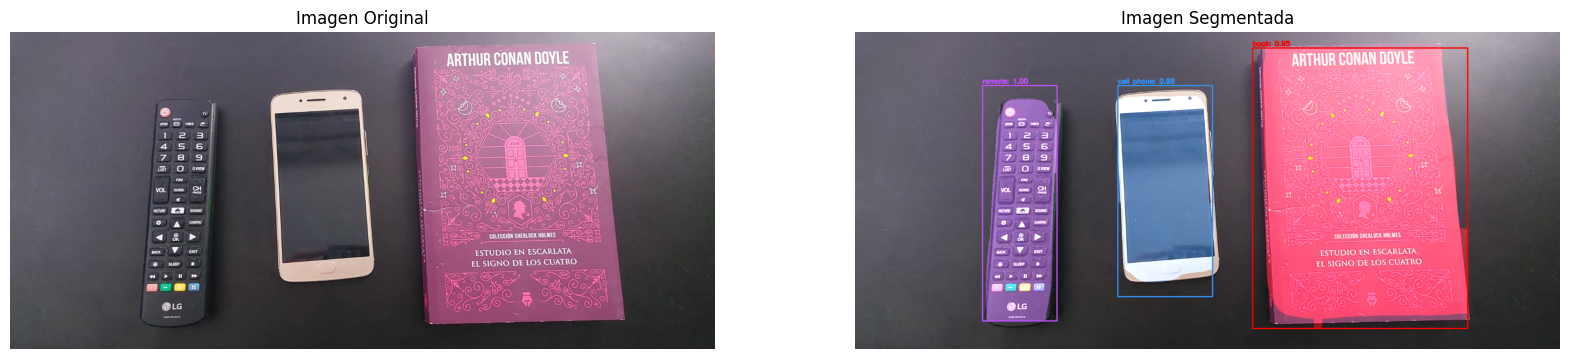

In [8]:
process_image_R_CNN('Escenarios/escenario_1.jpg')

### 4.1.2. **Segunda imagen (con solapamiento)**

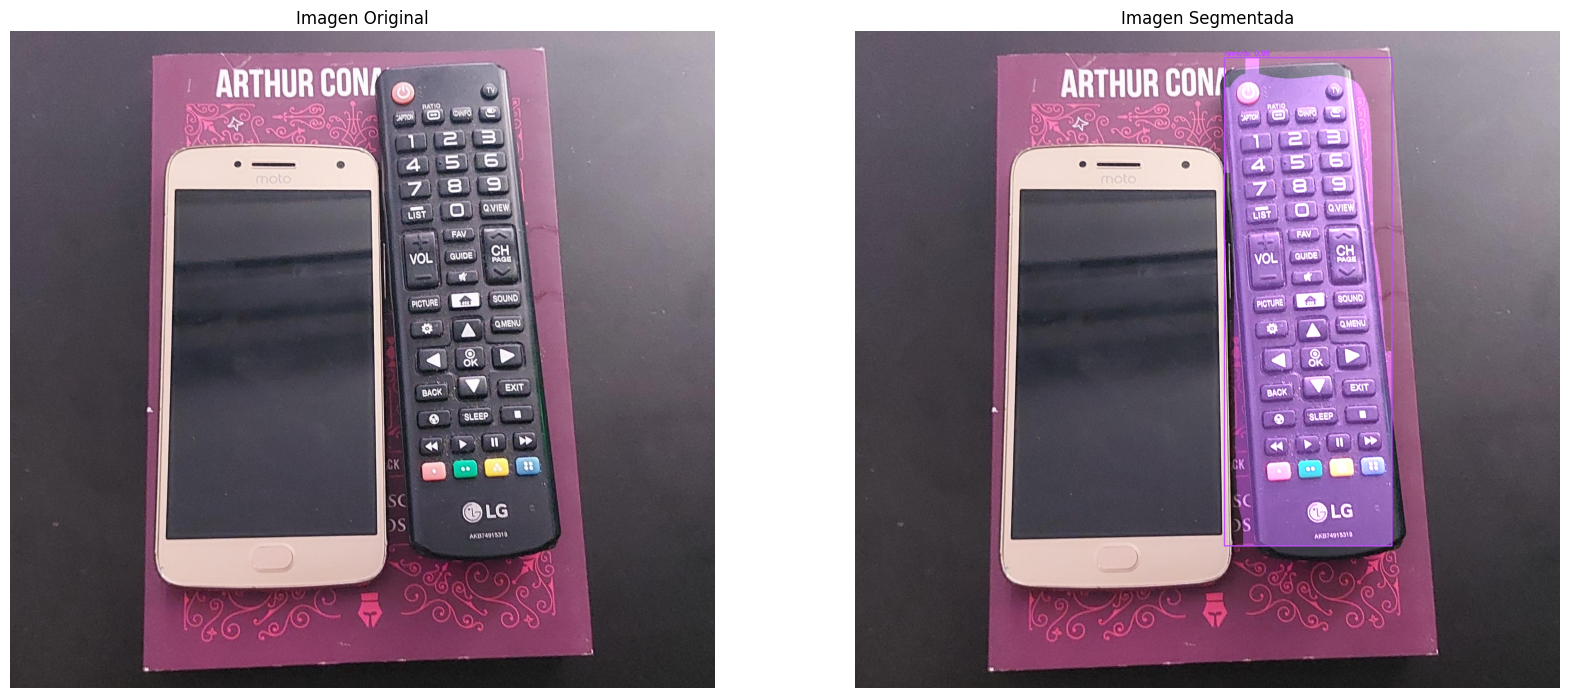

In [9]:
process_image_R_CNN('Escenarios/escenario_2.jpg')

## 4.2. *Segmentación SAM*

### 4.2.1. **Primera imagen (sin solapamiento)**

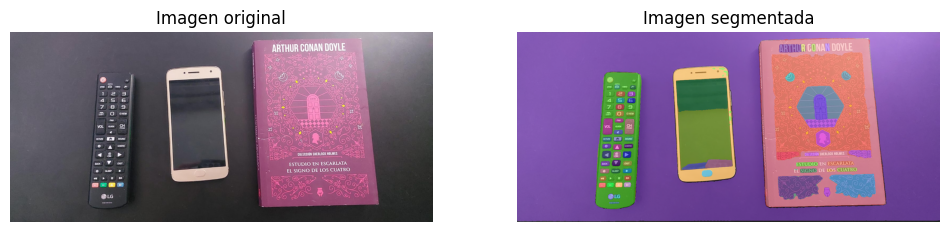

In [12]:
show_segmentation_SAM('Escenarios/escenario_1.jpg')

### 4.2.2. **Segunda imagen (con solapamiento)**

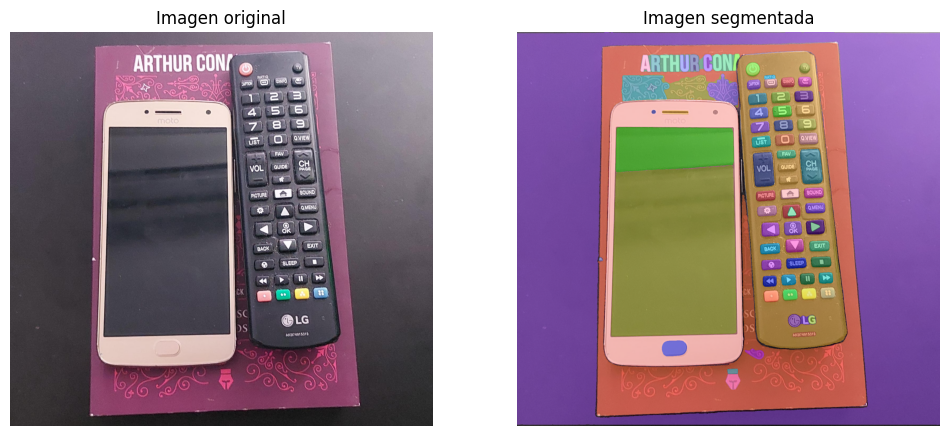

In [13]:
show_segmentation_SAM('Escenarios/escenario_2.jpg')

## 4.3. *Segmentación DETR ResNet50*

### 4.3.1. **Primera imagen (sin solapamiento)**

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
`post_process_panoptic is deprecated and will be removed in v5 o

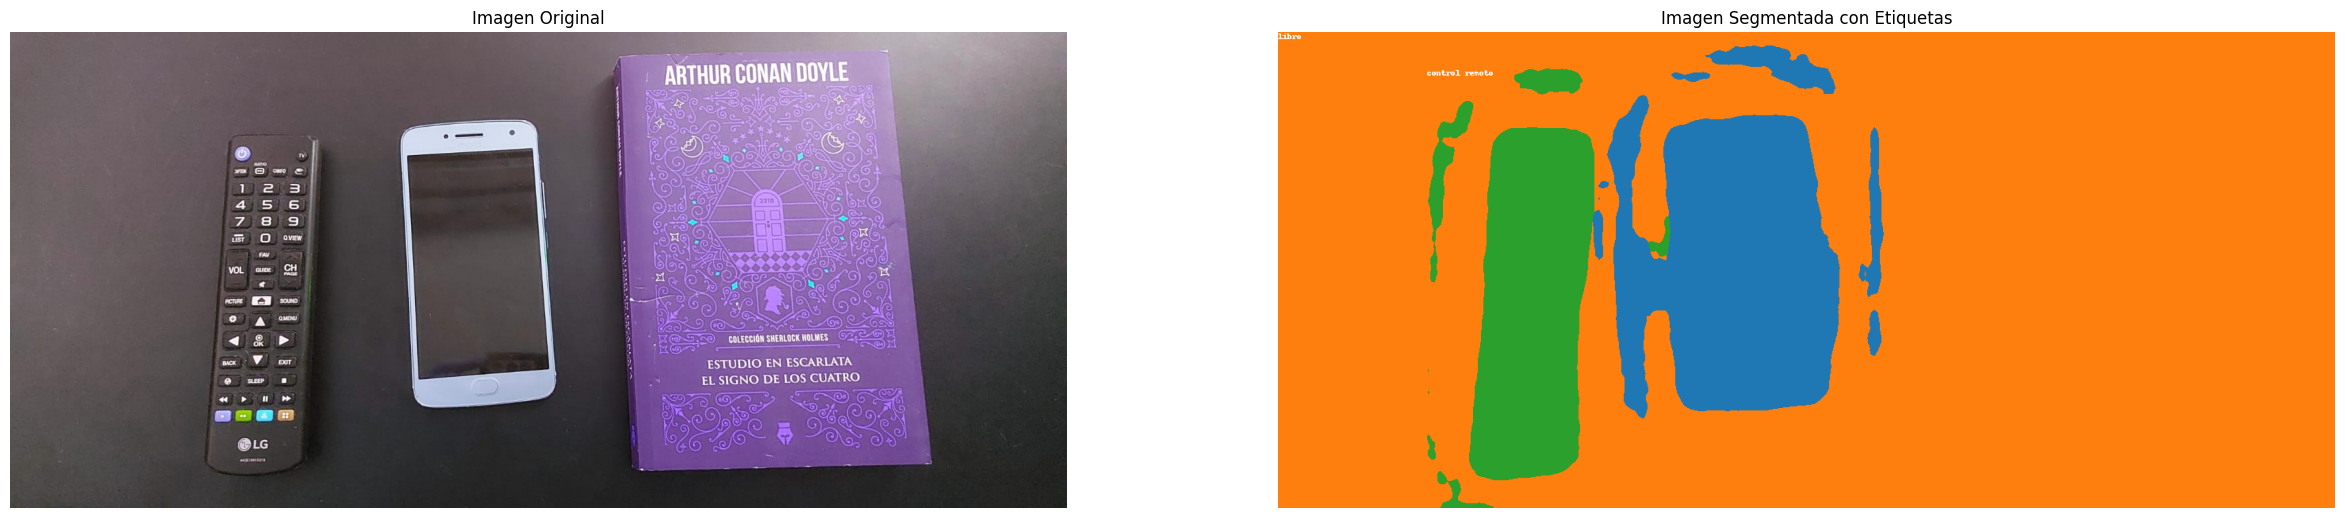

In [16]:
show_segmentation_DETR('Escenarios/escenario_1.jpg')

### 4.3.2. **Segunda imagen (con solapamiento)**

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


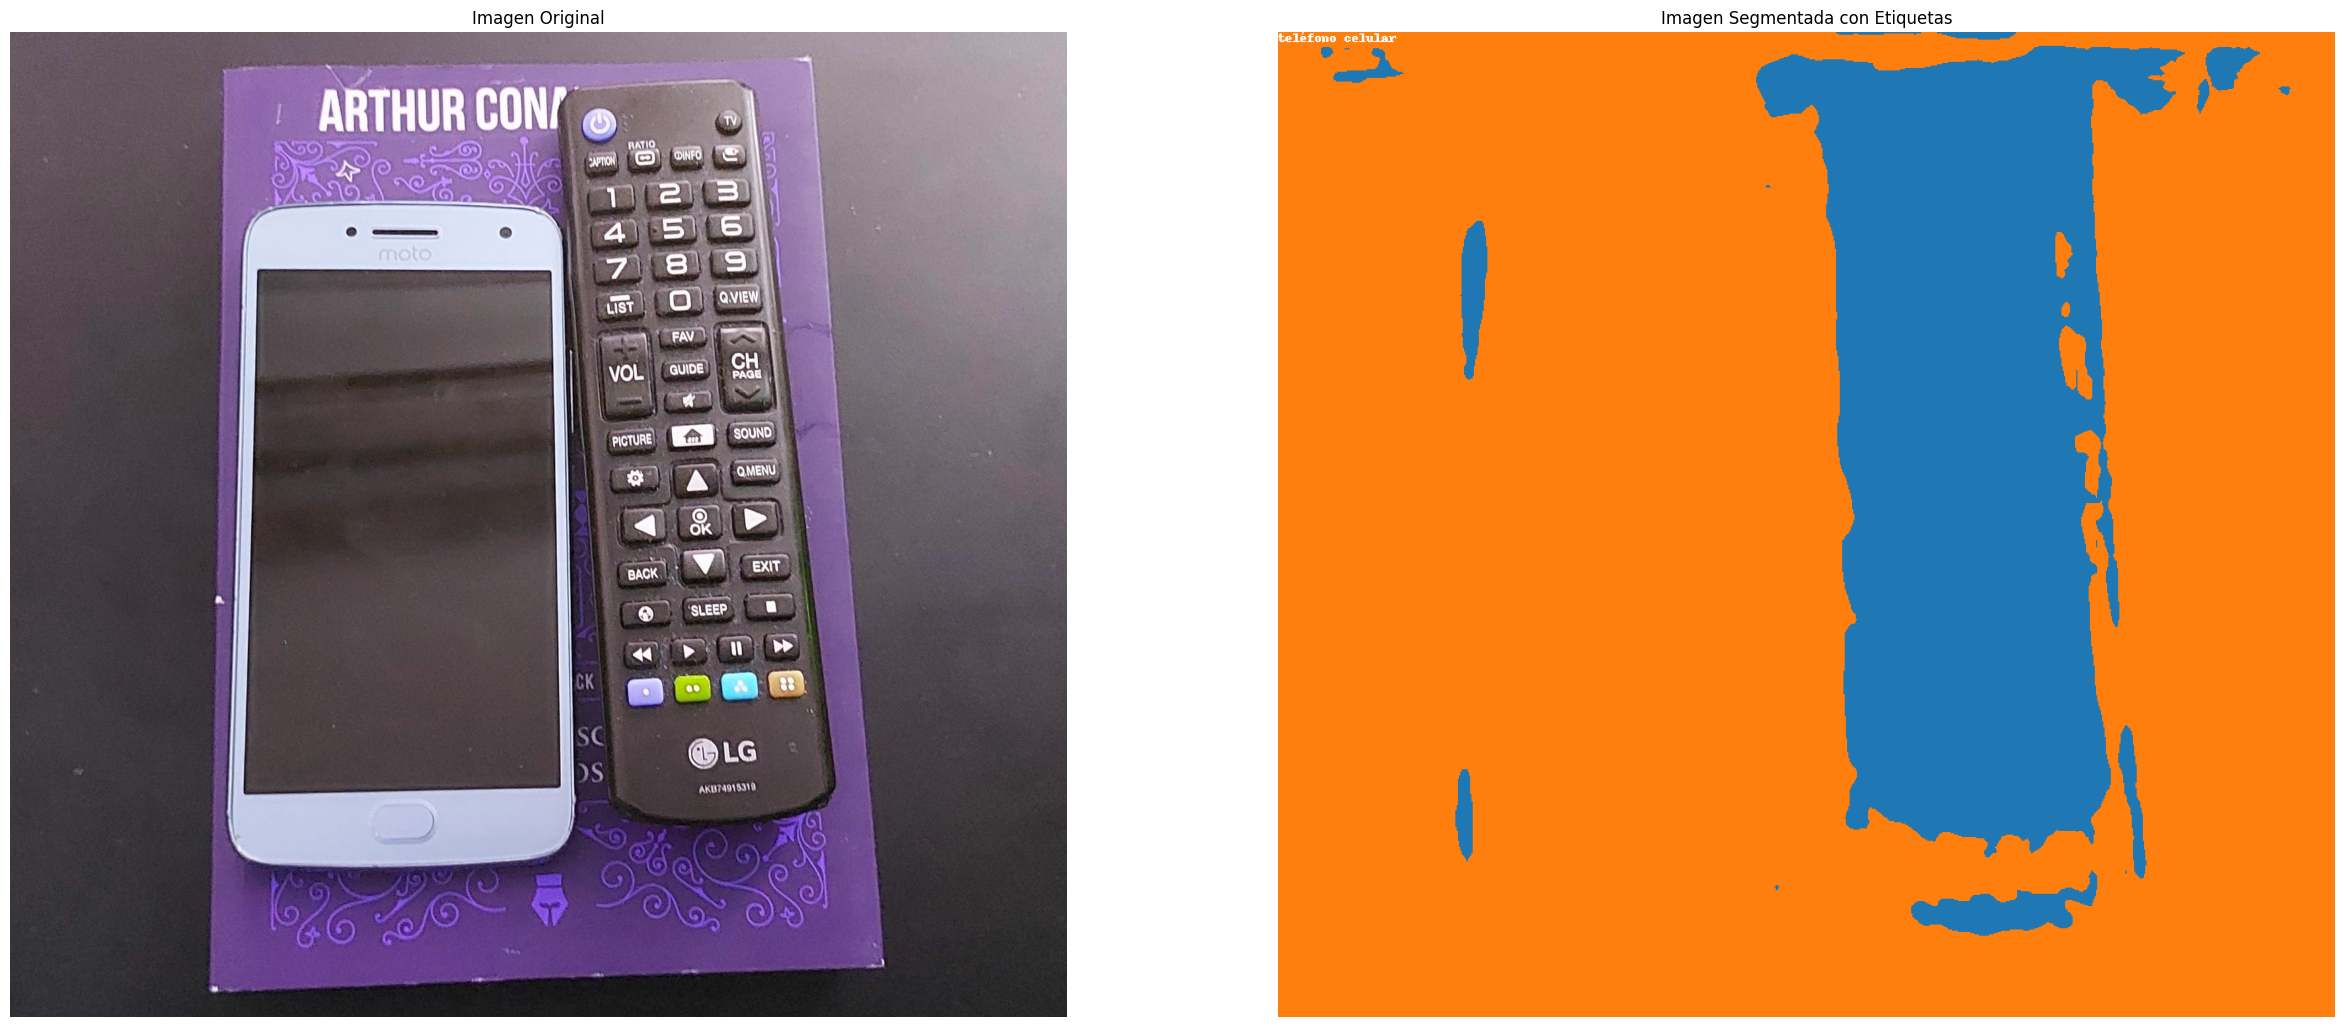

In [17]:
show_segmentation_DETR('Escenarios/escenario_2.jpg')

# 5. **Conclusiones**

En la primera imagen, donde los objetos están separados, noté que con Mask R-CNN se logró identificar correctamente las dimensiones y etiquetas de todos los objetos. También SAM hizo un buen trabajo al proporcionar una segmentación precisa de cada objeto. Sin embargo, DETR ResNet50 tuvo dificultades para identificar el libro, aunque pudo delimitar correctamente el celular y el control remoto.

En la segunda imagen, donde los objetos están solapados, me di cuenta de que con Mask R-CNN solo pudo identificar el control remoto debido al solapamiento de objetos. Por otro lado, SAM mantuvo una segmentación correcta de cada objeto, incluso con solapamientos. Pero DETR ResNet50 solo logró identificar el celular, y sus dimensiones no fueron totalmente precisas.

En resumen, cada algoritmo tiene sus propias fortalezas y debilidades en cuanto a la segmentación de objetos en imágenes. Mientras que algunos pueden lidiar mejor con situaciones de solapamiento, otros pueden enfrentar desafíos para identificar objetos en disposiciones inusuales.